# LSA vs LDA for text classification -- Capstone Project UDM 

In [1]:
import pandas as pd
import numpy as np 
import os 
import re
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [24]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
raw_data = pd.read_csv('/Users/aayush/Desktop/UDM/data.csv', parse_dates=[0], infer_datetime_format=True)
reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

raw_data.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


In [6]:
raw_data.shape

(1226258, 2)

In [16]:
df2 = df

## Pre-processing Text Data

In [17]:
# Dropping all NULL values from the dataset
df2 = df2.dropna()

# Converting all comments to lower case
df2['headline_clean'] = df2['headline_text'].str.lower()\

# Removing all punctuations from the comments like @+#/\
df2['headline_text'] = \
df2['headline_text'].map(lambda x: re.sub('[,\.!?&/@+-'']', '', x))

In [18]:
df2

,publish_date,headline_text,headline_clean
0,2003-02-19,aba decides against community broadcasting lic...,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers,air nz strike to affect australian travellers
...,...,...,...
1226253,2020-12-31,what abc readers learned from 2020 looking bac...,what abc readers learned from 2020 looking bac...
1226254,2020-12-31,what are the south african and uk variants of ...,what are the south african and uk variants of ...
1226255,2020-12-31,what victorias coronavirus restrictions mean f...,what victorias coronavirus restrictions mean f...
1226256,2020-12-31,whats life like as an american doctor during c...,whats life like as an american doctor during c...


In [21]:
# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('english')



# Removing all stop words from comments. 
df2['headline_clean'] = df2['headline_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df2[['headline_text', 'headline_clean']].head()

,headline_text,headline_clean
0,aba decides against community broadcasting lic...,aba decides community broadcasting licence
1,act fire witnesses must be aware of defamation,act fire witnesses must aware defamation
2,a g calls for infrastructure protection summit,g calls infrastructure protection summit
3,air nz staff in aust strike for pay rise,air nz staff aust strike pay rise
4,air nz strike to affect australian travellers,air nz strike affect australian travellers


In [25]:
all_words = df2['headline_clean'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        )
    )]

layout = go.Layout(
    title='Top 50 (cleaned) Word frequencies in the training dataset after removing stopwords'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# EDA--------------------------------------------------------------------------------------

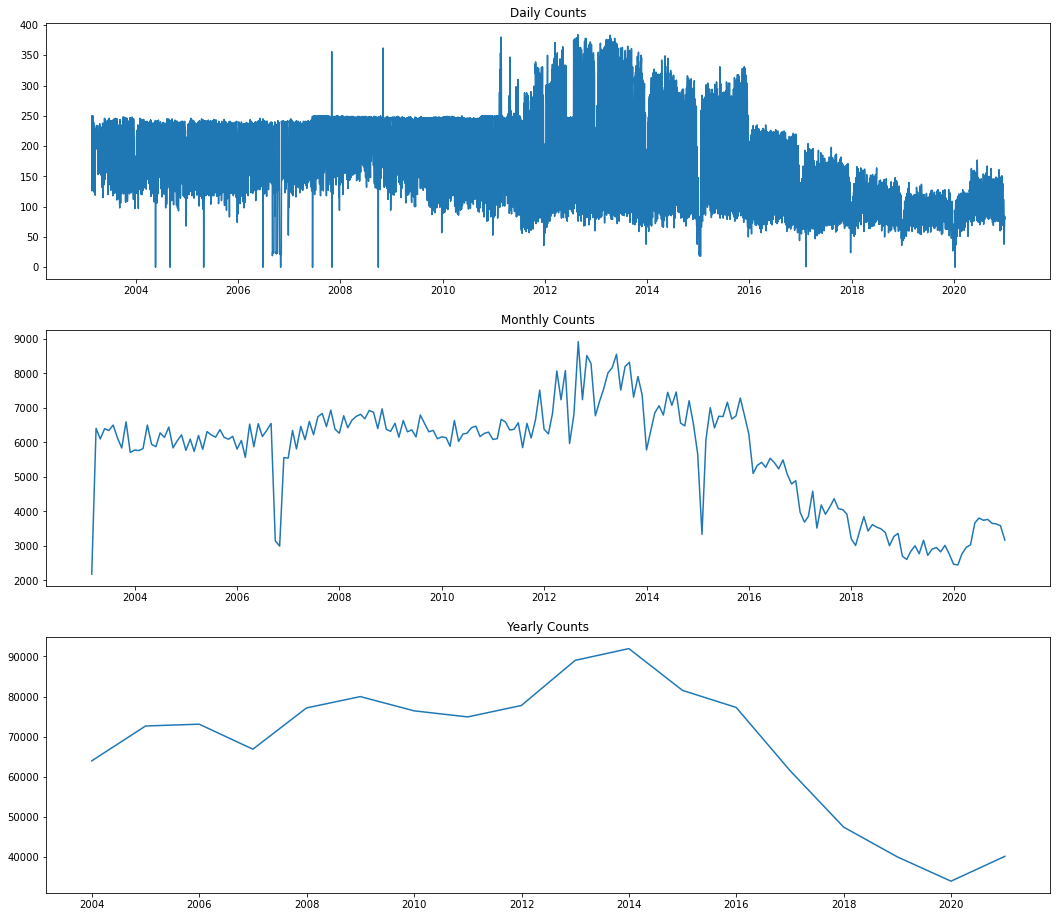

In [26]:
monthly_counts = reindexed_data.resample('M').count()
yearly_counts = reindexed_data.resample('A').count()
daily_counts = reindexed_data.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts);
ax[0].set_title('Daily Counts');
ax[1].plot(monthly_counts);
ax[1].set_title('Monthly Counts');
ax[2].plot(yearly_counts);
ax[2].set_title('Yearly Counts');
plt.show()

# Modelling--------------------------------------------------------------------------------

## MODEL #1: Latent Semantic Analysis(LSA)

### Model:  Latent Semantic Analysis (LSA)

**Model Overview** 
Let’s say we have m number of text documents with n number of total unique terms (words). We wish to extract k topics from all the text data in the documents. The number of topics, k, has to be specified by the user.

- Generate a document-term matrix of shape m x n having TF-IDF scores.
- Then, we will reduce the dimensions of the above matrix to k (no. of desired topics) dimensions, using singular-value decomposition (SVD).
- SVD decomposes a matrix into three other matrices. Suppose we want to decompose a matrix A using SVD. It will be decomposed into matrix U, matrix S, and VT (transpose of matrix V).


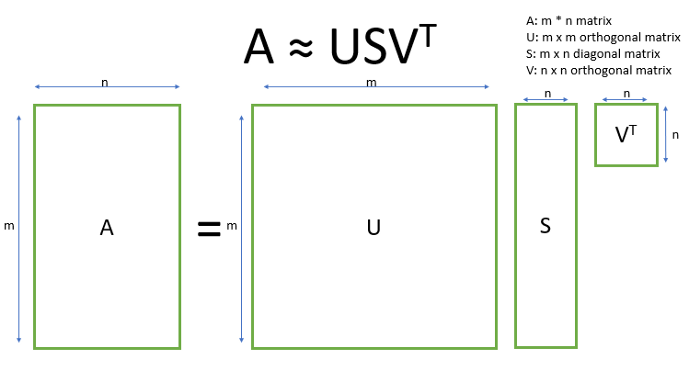

#### Model Parameters. 

- n_components: Desired dimensionality of output data. Must be strictly less than the number of features. For LSA, a value of 100 is recommended.

- algorithm: SVD solver to use. Either “arpack” for the ARPACK wrapper in SciPy (scipy.sparse.linalg.svds), or “randomized” for the randomized algorithm due to Halko (2009).

- n_iter: Number of iterations for randomized SVD solver. Not used by ARPACK. The default is larger than the default in randomized_svd to handle sparse matrices that may have large slowly decaying spectrum.

- random_state: RandomState instance or None, default=None, Used during randomized svd. Pass an int for reproducible results across multiple function calls.

reference: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords 
stop_words=set(nltk.corpus.stopwords.words('english'))

In [31]:
vect =TfidfVectorizer(stop_words=stop_words,max_features=5000)
vect_text=vect.fit_transform(df2['headline_clean'])

In [42]:
idf=vect.idf_
dd=dict(zip(vect.get_feature_names(), idf))
l=sorted(dd, key=(dd).get)
print(l[0],l[-1])

print(dd['police'])
print(dd['neck'])  

# police is most common and forecast is least common among the news headlines.

police neck
4.440676964340036
9.701358635440101


In [33]:
X = vect_text.toarray()
cvec = CountVectorizer(stop_words='english', min_df=1, max_df=.5, ngram_range=(1,2))
cvec

CountVectorizer(max_df=0.5, ngram_range=(1, 2), stop_words='english')

In [35]:
from itertools import islice
cvec.fit(df2['headline_clean'])
list(islice(cvec.vocabulary_.items(), 20))

[('aba', 36430),
 ('decides', 652094),
 ('community', 514314),
 ('broadcasting', 332066),
 ('licence', 1359378),
 ('aba decides', 36440),
 ('decides community', 652121),
 ('community broadcasting', 514462),
 ('broadcasting licence', 332096),
 ('act', 54570),
 ('witnesses', 2573625),
 ('aware', 196060),
 ('defamation', 656414),
 ('act witnesses', 56253),
 ('witnesses aware', 2573652),
 ('aware defamation', 196107),
 ('calls', 370170),
 ('infrastructure', 1193749),
 ('protection', 1810265),
 ('summit', 2257655)]

In [37]:
cvec_counts = cvec.transform(df2['headline_clean'])
print ('sparse matrix shape:', cvec_counts.shape)
print ('nonzero count:', cvec_counts.nnz)
print ('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

sparse matrix shape: (1226258, 2616466)
nonzero count: 11500853
sparsity: 0.00%


In [38]:
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

,term,occurrences
1740861,police,39385
1566598,new,32832
1423773,man,30514
2036558,says,23014
576176,court,18014
1018301,govt,17057
568006,council,16934
180124,australia,16652
1589654,nsw,15749
1210621,interview,15545


In [39]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<1226258x2616466 sparse matrix of type '<class 'numpy.float64'>'
	with 11500853 stored elements in Compressed Sparse Row format>

In [40]:
# Creating and training the LSA model.
lsa_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=40, random_state=5000)

lsa_top=lsa_model.fit_transform(vect_text)

In [41]:
l=lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
  print("Topic ",i," : ",topic*100)

Document 0 :
Topic  0  :  0.046025899639956305
Topic  1  :  1.0174955456134587
Topic  2  :  1.3352014866367734
Topic  3  :  -0.9873932973129446
Topic  4  :  -1.4461562455258954
Topic  5  :  -0.4564107661345774
Topic  6  :  0.015458042384246955
Topic  7  :  1.209830378171685
Topic  8  :  0.3215018446454977
Topic  9  :  -0.8754938744952735
Topic  10  :  0.022176114411216905
Topic  11  :  0.1034998419591047
Topic  12  :  -0.24281431879341073
Topic  13  :  0.5143956784300163
Topic  14  :  -0.13038422163762411
Topic  15  :  0.39652597794775185
Topic  16  :  -0.6156210232732684
Topic  17  :  -0.11383758659818442
Topic  18  :  0.2677718570716287
Topic  19  :  1.0868339706645898


In [45]:
# most important words for each topic
vocab = vect.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:20]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
interview extended michael david police john nrl james ben andrew matt smith scott mark chris peter man nathan luke ivan 

Topic 1: 
police man charged court murder new crash death missing car woman accused fire dies search sydney found nsw probe jailed 

Topic 2: 
new police says govt council nsw australia plan water us rural health wa qld fire probe sa government report call 

Topic 3: 
police investigate probe search hunt missing officer arrest seek fatal shooting witnesses say seize officers chase find suspicious warn raid 

Topic 4: 
new man police zealand charged york murder search laws stabbing missing jailed interview assault investigate hunt papua eve wales appoints 

Topic 5: 
rural news abc national nsw business weather market sport new man analysis reporter entertainment qld sa charged exchange speaks friday 

Topic 6: 
court accused murder face faces told charges case police trial front rural news abc sex high hears drug appeal death 

Topic 7: 
fire council govt

In [43]:
lsa_top=lsa_model.fit_transform(vect_text)
topic_values = lsa_top
df2['Topic'] = topic_values.argmax(axis=1)

In [44]:
df2

,publish_date,headline_text,headline_clean,Topic
0,2003-02-19,aba decides against community broadcasting lic...,aba decides community broadcasting licence,2
1,2003-02-19,act fire witnesses must be aware of defamation,act fire witnesses must aware defamation,9
2,2003-02-19,a g calls for infrastructure protection summit,g calls infrastructure protection summit,19
3,2003-02-19,air nz staff in aust strike for pay rise,air nz staff aust strike pay rise,2
4,2003-02-19,air nz strike to affect australian travellers,air nz strike affect australian travellers,19
...,...,...,...,...
1226253,2020-12-31,what abc readers learned from 2020 looking bac...,abc readers learned 2020 looking back year,13
1226254,2020-12-31,what are the south african and uk variants of ...,south african uk variants covid 19,10
1226255,2020-12-31,what victorias coronavirus restrictions mean f...,victorias coronavirus restrictions mean new ye...,2
1226256,2020-12-31,whats life like as an american doctor during c...,whats life like american doctor covid,1


In [47]:
# most important words for each topic
vocab = vect.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:4]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    (print("\n"))

Topic 0: 
interview extended michael david 

Topic 1: 
police man charged court 

Topic 2: 
new police says govt 

Topic 3: 
police investigate probe search 

Topic 4: 
new man police zealand 

Topic 5: 
rural news abc national 

Topic 6: 
court accused murder face 

Topic 7: 
fire council govt water 

Topic 8: 
says man council govt 

Topic 9: 
fire says court house 

Topic 10: 
australia day fire man 

Topic 11: 
us council abc fire 

Topic 12: 
us nsw rural govt 

Topic 13: 
govt abc weather business 

Topic 14: 
govt australia us crash 

Topic 15: 
death charged murder trial 

Topic 16: 
nsw abc council australia 

Topic 17: 
found missing murder woman 

Topic 18: 
water plan restrictions australia 

Topic 19: 
death health australian man 



In [52]:
#Create df based on top keywords
def show_topics(TfidfVectorizer, lsa_model=lsa_model, n_words=2):
    keywords = np.array(vect.get_feature_names())
    topic_keywords = []
    for topic_weights in lsa_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(TfidfVectorizer, lsa_model=lsa_model, n_words=4)        

# Topic - Keywords Dataframe
top_keywords = pd.DataFrame(topic_keywords)
top_keywords.columns = ['KeyWord '+str(i) for i in range(top_keywords.shape[1])]
top_keywords.index = ['LSA_Topic '+str(i) for i in range(top_keywords.shape[0])]
top_keywords.head

<bound method NDFrame.head of               KeyWord 0    KeyWord 1     KeyWord 2  KeyWord 3
LSA_Topic 0   interview     extended       michael      david
LSA_Topic 1      police          man       charged      court
LSA_Topic 2         new       police          says       govt
LSA_Topic 3      police  investigate         probe     search
LSA_Topic 4         new          man        police    zealand
LSA_Topic 5       rural         news           abc   national
LSA_Topic 6       court      accused        murder       face
LSA_Topic 7        fire      council          govt      water
LSA_Topic 8        says          man       council       govt
LSA_Topic 9        fire         says         court      house
LSA_Topic 10  australia          day          fire        man
LSA_Topic 11         us      council           abc       fire
LSA_Topic 12         us          nsw         rural       govt
LSA_Topic 13       govt          abc       weather   business
LSA_Topic 14       govt    australia    

In [53]:
top_keywords['Topic'] = np.arange(top_keywords.shape[0])

In [54]:
# Merging DF2 and LSA output
mergedDF = pd.merge(df2,top_keywords, on="Topic")

In [55]:
mergedDF

,publish_date,headline_text,headline_clean,Topic,KeyWord 0,KeyWord 1,KeyWord 2,KeyWord 3
0,2003-02-19,aba decides against community broadcasting lic...,aba decides community broadcasting licence,2,new,police,says,govt
1,2003-02-19,air nz staff in aust strike for pay rise,air nz staff aust strike pay rise,2,new,police,says,govt
2,2003-02-19,antic delighted with record breaking barca,antic delighted record breaking barca,2,new,police,says,govt
3,2003-02-19,barca take record as robson celebrates birthda...,barca take record robson celebrates birthday,2,new,police,says,govt
4,2003-02-19,bathhouse plans move ahead,bathhouse plans move ahead,2,new,police,says,govt
...,...,...,...,...,...,...,...,...
1226253,2020-11-19,us lifts boeing 737 max flight ban after crash...,us lifts boeing 737 max flight ban crash probes,14,govt,australia,us,crash
1226254,2020-11-24,scott morrison china us australia indo pacific,scott morrison china us australia indo pacific,14,govt,australia,us,crash
1226255,2020-12-02,parler downloads surged in australia after us ...,parler downloads surged australia us election,14,govt,australia,us,crash
1226256,2020-12-08,nt worksafe charges fatal central australia he...,nt worksafe charges fatal central australia he...,14,govt,australia,us,crash


## Model #2: Latent Dirichlet Allocation (LDA)

In [56]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')


data_vectorized = vectorizer.fit_transform(df2["headline_clean"])

In [57]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1) 
# n_components is the number of topics

In [58]:
lda_top=lda_model.fit_transform(data_vectorized)


In [59]:
print(lda_top.shape)  # (no_of_doc,no_of_topics)
print(lda_top)

(1226258, 10)
[[0.01666667 0.0166668  0.01666667 ... 0.18333063 0.01666667 0.01666667]
 [0.02       0.02       0.02       ... 0.82       0.02       0.02      ]
 [0.62000002 0.02       0.02       ... 0.02       0.02       0.02      ]
 ...
 [0.0125     0.1375     0.01250092 ... 0.15014399 0.0125     0.37455085]
 [0.15714285 0.01428986 0.01428571 ... 0.15714284 0.01428571 0.01428571]
 [0.01666667 0.18333334 0.35       ... 0.01666667 0.18333331 0.01666667]]


In [60]:
# composition of doc 0 for eg
print("Document 0: ")
for i,topic in enumerate(lda_top[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  1.6666666718455292 %
Topic  1 :  1.6666799551453324 %
Topic  2 :  1.6666666787795923 %
Topic  3 :  1.6666666688400753 %
Topic  4 :  68.33358997886766 %
Topic  5 :  1.6666666724880586 %
Topic  6 :  1.666666668868951 %
Topic  7 :  18.333063223317843 %
Topic  8 :  1.666666668942221 %
Topic  9 :  1.666666812904733 %


In [61]:
print(lda_model.components_)
print(lda_model.components_.shape)  # (no_of_topics*no_of_words)

[[1.00001416e-01 1.00002840e-01 1.00056574e-01 ... 1.00027201e-01
  1.00000001e-01 1.00000347e-01]
 [1.00001901e-01 1.00004341e-01 1.00029743e-01 ... 1.00058461e-01
  1.00000001e-01 1.00000308e-01]
 [1.00020175e-01 1.00004832e-01 1.00014616e-01 ... 1.00039318e-01
  1.00000005e-01 1.00000479e-01]
 ...
 [1.00010189e-01 1.11113485e+02 1.00022131e-01 ... 1.37142635e+02
  1.00000064e-01 1.00000453e-01]
 [1.00017947e-01 1.00011738e-01 1.00108685e-01 ... 1.00038990e-01
  1.00000295e-01 1.00000315e-01]
 [1.00020367e-01 1.00006979e-01 1.01655085e-01 ... 1.00006339e-01
  1.00000003e-01 1.23244265e-01]]
(10, 37777)


In [62]:
# most important words for each topic
vocab = vect.get_feature_names()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
grow attracts minimum democracy brothel burnett exports parliament pilot korea 

Topic 1: 
sees plans kangaroos sends settlement poll screen wanted grass cyber 

Topic 2: 
waratahs 23 suicide masters fees subsidy highest drum staffing xi 

Topic 3: 
analysis wary trade affected rider failing doctor chief confusion wins 

Topic 4: 
grower dean mean orders obesity airline know albanese congress longreach 

Topic 5: 
game cambodian fitness mental crimes bravery crime childcare intelligence missed 

Topic 6: 
suspend pirates hour armed struggle demand muslims diabetes restaurant tech 

Topic 7: 
blues exposed arabia ward francis knights counselling tribute gunners survives 

Topic 8: 
groups bill pull sitting walsh register good cfmeu paying days 

Topic 9: 
considers child growers acid washington gardens retire schumacher starting ditch 



In [63]:
import pyLDAvis.sklearn
import warnings
warnings.filterwarnings('ignore')

In [64]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5      32.420952   8.115230       1        1  10.459366
0       0.648955  71.707100       2        1  10.395441
3      71.019684   9.971006       3        1  10.366614
9       3.785981  33.185135       4        1  10.324580
1     -42.666500  -9.222070       5        1  10.109415
6      -3.621689 -43.526516       6        1   9.926577
7      -3.632402  -4.171708       7        1   9.821199
2     -36.584400  35.804413       8        1   9.657433
8      44.391380  50.615383       9        1   9.639470
4      40.235809 -31.591665      10        1   9.299904, topic_info=              Term          Freq         Total Category  logprob  loglift
2002     australia  35554.000000  35554.000000  Default  30.0000  30.0000
7614   coronavirus  79825.000000  79825.000000  Default  29.0000  29.0000
25526       police  31585.000000  31585.000000  Default  28.0000  28.0000
22842          new  29995.000000  29995.000000  Default  27.0000  27.0000
7803         covid  35833.000000  35833.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
34852     turnbull   2755.956202   2756.720133  Topic10  -5.3272   2.3749
12353        fires   2739.749488   2740.513479  Topic10  -5.3331   2.3749
2751           bay   2470.378084   2471.142060  Topic10  -5.4366   2.3749
7803         covid   7438.963997  35833.887717  Topic10  -4.3342   0.8030
7614   coronavirus   9091.391810  79825.191863  Topic10  -4.1336   0.2027

[341 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
33         8  0.999837         abc
89         4  0.999778  aboriginal
134        3  0.999927       abuse
216        3  0.999948     accused
274        7  0.999710         act
...      ...       ...         ...
37525      8  0.999931        year
37528      7  0.999906       years
37599      3  0.999844       young
37612      9  0.999870       youth
37683      4  0.999723     zealand

[315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 4, 10, 2, 7, 8, 3, 9, 5])